## Estimating pi with a random number generator

Recently, a friend asked me if I knew about Monte Carlo and told me that the number PI can be estimated with random numbers.

I then decided to see if I could do that without looking up the solution.

Here it goes...

### Import stuff

In [1]:
%pip install "matplotlib<4" "numpy<2"

import numpy as np
import matplotlib.pyplot as plt

# Set the global grid property
plt.rcParams['axes.grid'] = True

# Initialize random number generator
rng = np.random.default_rng(seed=42)


Note: you may need to restart the kernel to use updated packages.


### Generate random points (x, y pairs) uniformly distributed in the unit square

In [2]:
number_of_pairs = 1_000

# Generate both axes
xy = rng.uniform(0, 1, number_of_pairs * 2)

# Split into x and y
x, y = np.array_split(xy, 2)


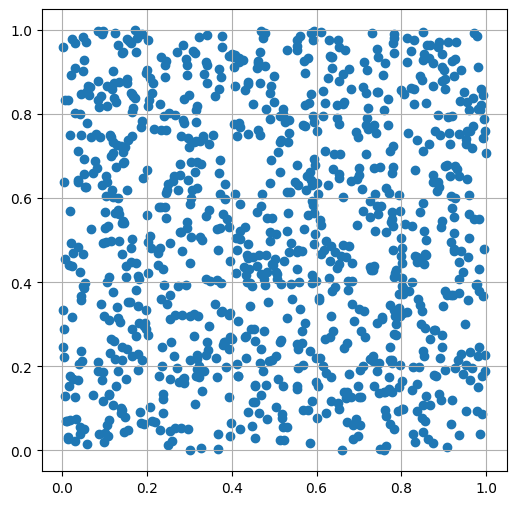

In [3]:
def show_scatter(x, y):
    plt.figure(figsize=(6, 6))
    plt.scatter(x, y)
    plt.grid(True)
    plt.show()

show_scatter(x, y)


## Remove points outside of the unit circle

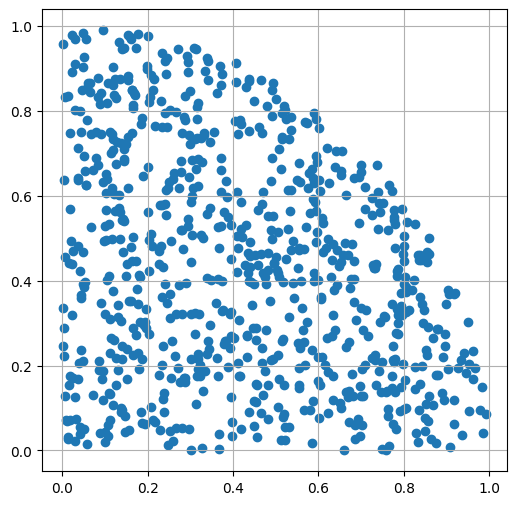

In [4]:
mask = x**2 + y**2 <= 1
x = x[mask]
y = y[mask]

show_scatter(x, y)


## Map all points on the circle border

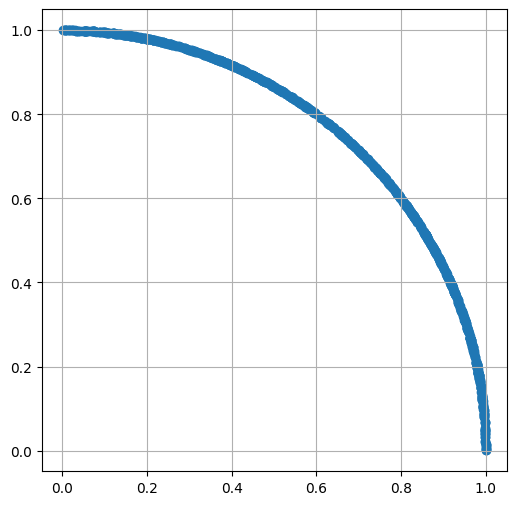

In [5]:
distances_from_origin = np.sqrt(x**2 + y**2)

x = np.divide(x, distances_from_origin)
y = np.divide(y, distances_from_origin)

show_scatter(x, y)


## Observe the distribution of x

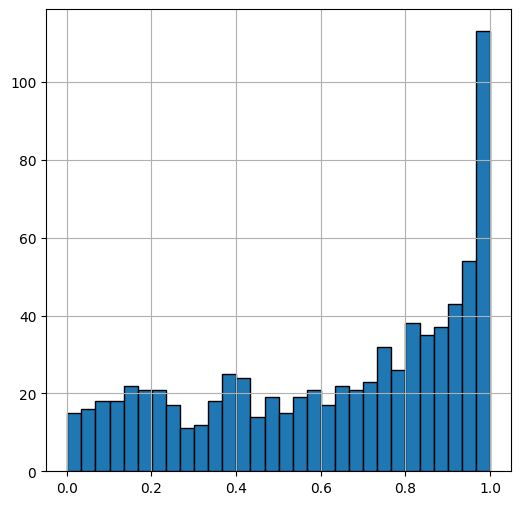

In [6]:
def show_histogram(x, bins: int = 30):
    plt.figure(figsize=(6, 6))
    plt.hist(x, bins=bins, edgecolor='black')
    plt.show()

show_histogram(x)


As we get from x=0 to x=1, the circle border gets more perpendicular to the x axis, and the x values of the random numbers are more condensed.

## Get all the distances between x values

In [7]:
def get_counterpart(x_or_y):
    """
    Given an x value between 0 and 1,
      find the y value that maps
      that x value on the unit circle.
    Works x->y and y->x.
    """
    return np.sqrt(np.ones(x_or_y.shape) - x_or_y**2)

def get_euclidian_distances(x1, x2):
    """
    Given two x matrices,
      find the euclidian distance between their
      corresponding points on the unit circle.
    It is an element-wise operation.
    """
    y1 = get_counterpart(x1)
    y2 = get_counterpart(x2)
    return np.sqrt((x1 - x2)**2 + (y1 -y2)**2)

x.sort()

# Obtain each distance between neighboring points on the unit circle
distances = get_euclidian_distances(x[:-1], x[1:])


## Estime pi by summing the distances (obtaining the length of the quarter circle)

In [8]:
quarter_circle_circumference = np.sum(distances)

# pi is half a complete circle
pi = quarter_circle_circumference * 2

print(pi)


3.1375185348374206


## Grid search various numbers of points on the circle to observe convergence

In [9]:
import math
from time import perf_counter

def estimate_pi(points_inside_unit_square: int) -> float:
    """
    Given an amount of number of random points, estimate pi.
    """

    # Generate points
    xy = rng.uniform(0, 1, points_inside_unit_square * 2)
    x, y = np.array_split(xy, 2)

    # Remove points outside of circle
    mask = x**2 + y**2 <= 1
    x = x[mask]
    y = y[mask]

    # Carry x values to the circle border
    distances_from_origin = np.sqrt(x**2 + y**2)
    x = np.divide(x, distances_from_origin)

    # Sum over the distances between points on circle
    x.sort()
    distances = get_euclidian_distances(x[:-1], x[1:])
    return np.sum(distances) * 2


def get_error(pi_estimation: float) -> float:
    """
    Get the relative error of the pi estimation.
    """
    return abs(pi_estimation - math.pi) / math.pi


numbers_of_points_inside_unit_square = [
    10_000, 100_000, 1_000_000,
    10_000_000, 100_000_000
]
errors = []

start_time = perf_counter()
for number_of_points_inside_unit_square in numbers_of_points_inside_unit_square:
    pi = estimate_pi(number_of_points_inside_unit_square)
    error = get_error(pi)
    errors.append(error)
    print(f"{number_of_points_inside_unit_square=:>15}, {error=:.10f}")
end_time = perf_counter()

print(f"\nCircumference method took: {end_time - start_time} seconds.")
    

number_of_points_inside_unit_square=          10000, error=0.0000264447
number_of_points_inside_unit_square=         100000, error=0.0000401923
number_of_points_inside_unit_square=        1000000, error=0.0000037544
number_of_points_inside_unit_square=       10000000, error=0.0000001447
number_of_points_inside_unit_square=      100000000, error=0.0000000194

Circumference method took: 14.25504916600039 seconds.


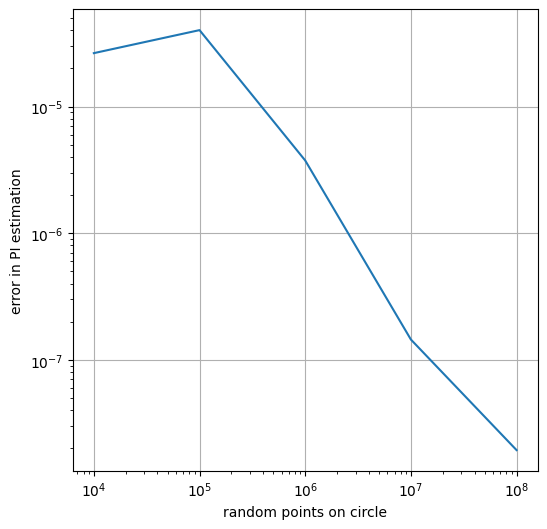

In [10]:
plt.figure(figsize=(6, 6))
plt.plot(numbers_of_points_inside_unit_square, errors)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('random points on circle')
plt.ylabel('error in PI estimation')
plt.show()


### UPDATE

I showed this to my friend and found out that I did not have to make this as complicated as it is.

Here is a version that uses the numbers of points before and after cleaning the points inside the square, outside the circle.

In [11]:
def estimate_pi_area(number_of_points_inside_unit_square) -> float:
    xy = rng.uniform(0, 1, number_of_points_inside_unit_square * 2)
    x, y = np.array_split(xy, 2)

    mask = x**2 + y**2 <= 1
    number_of_points_inside_unit_circle = np.sum(mask)

    # pi * r^2 (r=1) = pi (our quarter circle is pi / 4)
    entire_circle_area = number_of_points_inside_unit_circle * 4

    return entire_circle_area / number_of_points_inside_unit_square

errors_area = []

start_time = perf_counter()
for number_of_points_inside_unit_square in numbers_of_points_inside_unit_square:
    pi = estimate_pi_area(number_of_points_inside_unit_square)
    error_area = get_error(pi)
    errors_area.append(error_area)
    print(f"{number_of_points_inside_unit_square=:>15}, {error_area=:.10f}")
end_time = perf_counter()

print(f"\Area method took: {end_time - start_time} seconds.")


number_of_points_inside_unit_square=          10000, error_area=0.0077644228
number_of_points_inside_unit_square=         100000, error_area=0.0013137752
number_of_points_inside_unit_square=        1000000, error_area=0.0000978314
number_of_points_inside_unit_square=       10000000, error_area=0.0000083568
number_of_points_inside_unit_square=      100000000, error_area=0.0000315297
\Area method took: 1.3466923750020214 seconds.


Let's see if we can get closer sparing some of the gained speed.

In [12]:
start_time = perf_counter()
largest_amount_in_list = numbers_of_points_inside_unit_square[-1]

# 4 times the largest example in circumference method
larger_amount_test_area = largest_amount_in_list * 4
pi = estimate_pi_area(larger_amount_test_area)
error_area = get_error(pi)
errors_area.append(error_area)
print(f"{number_of_points_inside_unit_square=:>15}, {error_area=:.10f}")
end_time = perf_counter()

print(f"\Area method with {larger_amount_test_area:_} took: {end_time - start_time} seconds.")


number_of_points_inside_unit_square=      100000000, error_area=0.0000055947
\Area method with 400_000_000 took: 32.012539082999865 seconds.


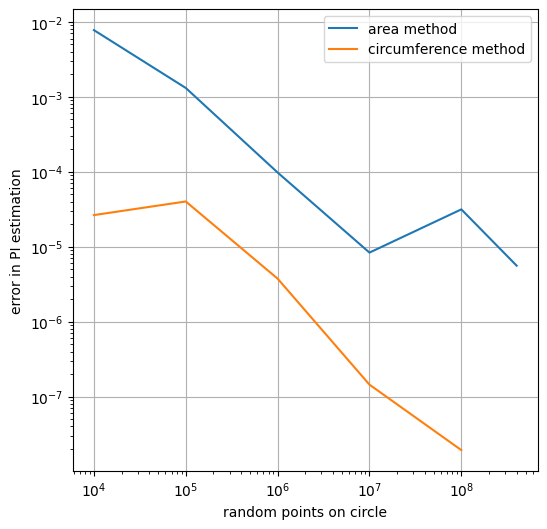

In [13]:
plt.figure(figsize=(6, 6))
plt.plot(numbers_of_points_inside_unit_square + [larger_amount_test_area],
         errors_area, label="area method")
plt.plot(numbers_of_points_inside_unit_square, errors, label="circumference method")
plt.xscale("log")
plt.yscale("log")
plt.xlabel('random points on circle')
plt.ylabel('error in PI estimation')
plt.legend()
plt.show()


The area method is much much simpler. After learning about it, I was a bit ashamed of having added all that [complexity](https://grugbrain.dev/#grug-on-complexity), but it turns out it was improving performance. Let's drop one final plot to better compare runtimes and call it a day.

In [14]:
def estimate_pi_circumference_with_time(
        number_of_points_inside_unit_square
    ) -> tuple:
    """
    Estimate pi with circumference method.
    Returns a tuple with error in pi estimation, and the runtime.
    """
    start_time = perf_counter()
    pi = estimate_pi(number_of_points_inside_unit_square)
    error = get_error(pi)
    print(f"{number_of_points_inside_unit_square=:>15}, {error=:.10f}")
    end_time = perf_counter()
    return (error, end_time - start_time)


def estimate_pi_area_with_time(
        number_of_points_inside_unit_square
    ) -> tuple:
    """
    Estimate pi with area method.
    Returns a tuple with error in pi estimation, and the runtime.
    """
    start_time = perf_counter()
    pi = estimate_pi_area(number_of_points_inside_unit_square)
    error_area = get_error(pi)
    print(f"{number_of_points_inside_unit_square=:>15}, {error_area=:.10f}")
    end_time = perf_counter()
    return (error_area, end_time - start_time)

numbers_of_points_inside_unit_square = [
    10_000, 100_000, 1_000_000,
    10_000_000, 100_000_000
]
errors_circumference = []
runtimes_circumference = []
errors_area = []
runtimes_area = []

for number_of_points_inside_unit_square in numbers_of_points_inside_unit_square:
    error_circumference, runtime_circumference = (
        estimate_pi_circumference_with_time(number_of_points_inside_unit_square)
    )
    errors_circumference.append(error_circumference)
    runtimes_circumference.append(runtime_circumference)

    error_area, runtime_area = (
        estimate_pi_area_with_time(number_of_points_inside_unit_square)
    )
    errors_area.append(error_area)
    runtimes_area.append(runtime_area)

larger_amount_test_area = numbers_of_points_inside_unit_square[-1] * 5
error_area, runtime_area = estimate_pi_area_with_time(larger_amount_test_area)
errors_area.append(error_area)
runtimes_area.append(runtime_area)


number_of_points_inside_unit_square=          10000, error=0.0006619905
number_of_points_inside_unit_square=          10000, error_area=0.0038220571
number_of_points_inside_unit_square=         100000, error=0.0000117467
number_of_points_inside_unit_square=         100000, error_area=0.0001423948
number_of_points_inside_unit_square=        1000000, error=0.0000034482
number_of_points_inside_unit_square=        1000000, error_area=0.0004785300
number_of_points_inside_unit_square=       10000000, error=0.0000003295
number_of_points_inside_unit_square=       10000000, error_area=0.0001714588
number_of_points_inside_unit_square=      100000000, error=0.0000000743
number_of_points_inside_unit_square=      100000000, error_area=0.0001217046
number_of_points_inside_unit_square=      500000000, error_area=0.0000182473


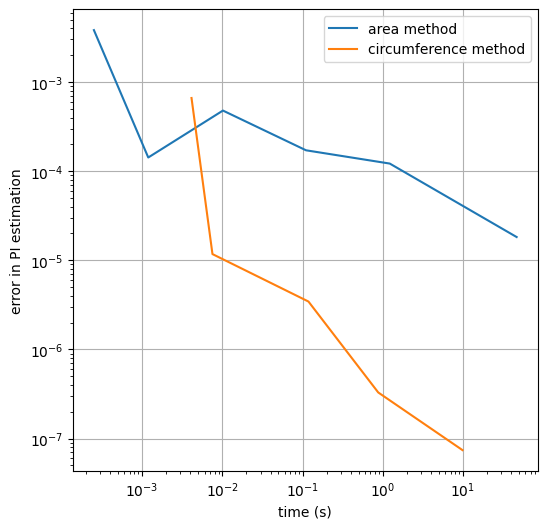

In [15]:
plt.figure(figsize=(6, 6))
plt.plot(runtimes_area, errors_area, label="area method")
plt.plot(runtimes_circumference, errors_circumference,
         label="circumference method")
plt.xscale("log")
plt.yscale("log")
plt.xlabel('time (s)')
plt.ylabel('error in PI estimation')
plt.legend()
plt.show()
